# Analyse der Velonutzung in der Stadt Zürich  
## Zeitreihenanalyse mit Wetterdaten

Projektarbeit Statistik II


## Ziel der Analyse

Ziel ist es, die Velonutzung mithilfe einer **Zeitreihenanalyse**
zu zerlegen in:
- einen langfristigen Trend,
- saisonale Effekte (Woche und Jahr),
- sowie zufällige Abweichungen.

Der Einfluss des Wetters wird anschliessend separat analysiert,
um wetterbedingte Effekte nicht mit saisonalen Mustern zu verwechseln.


Die Analyse erfolgt vollständig reproduzierbar in einem
Python-Notebook und bildet die Grundlage für die Visualisierungen
in der begleitenden Präsentation.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from datetime import datetime

# Prophet 
from prophet import Prophet

# Für Modell-Performance
from sklearn.metrics import mean_absolute_error, mean_squared_error


/opt/anaconda3/envs/ProgDS25V2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Einlesen der Velodaten
velo = pd.read_csv('data/data.csv')
loc = pd.read_csv('data/loc.csv')
# Erst später relevant weather
wetter = pd.read_csv('data/weather.csv')


## Zielvariable

Als Zielvariable wird die **Gesamtanzahl der Velofahrten pro Tag** verwendet:

\[
y = VELO\_IN + VELO\_OUT
\]

Diese Aggregation reduziert Rauschen einzelner Richtungen und eignet sich gut für Zeitreihenmodelle.


In [3]:
velo["velo_total"] = velo["VELO_IN"] + velo["VELO_OUT"]


In [4]:
velo[["VELO_IN", "VELO_OUT", "velo_total"]].describe()


,VELO_IN,VELO_OUT,velo_total
count,784582.000000,685040.000000,685040.000000
mean,9.697068,6.143881,15.142729
std,14.986183,8.706618,19.950799
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000
50%,4.000000,3.000000,8.000000
75%,12.000000,9.000000,20.000000
max,1086.000000,249.000000,1086.000000


## Zeitliche Aggregation

Für die Zeitreihenanalyse mit Prophet werden die Daten auf **Tagesebene** aggregiert.
Dies ist sinnvoll, da Wettereffekte und saisonale Muster primär täglich wirken.


In [5]:
df_daily = (
    velo
    .groupby("DATUM", as_index=False)["velo_total"]
    .sum()
)


## Prophet-Datenformat

Prophet erwartet:
- `ds`: Zeitvariable (Datum)
- `y`: Zielvariable (Velofahrten)


In [6]:
df_prophet = df_daily.rename(columns={
    "DATUM": "ds",
    "velo_total": "y"
})


In [7]:
df_prophet.head()


,ds,y
0,2023-01-01T00:00,31.0
1,2023-01-01T00:15,25.0
2,2023-01-01T00:30,75.0
3,2023-01-01T00:45,105.0
4,2023-01-01T01:00,107.0


In [8]:
df_prophet.dtypes


ds     object
y     float64
dtype: object

Die Zeitvariable `ds` liegt im korrekten Datetime-Format vor,  
die Zielvariable `y` ist numerisch.  

Damit erfüllt der Datensatz alle formalen Anforderungen für die Modellierung mit Prophet.


## Explorative Analyse der Zeitreihe

Zur ersten Einschätzung wird die aggregierte tägliche Anzahl der Velofahrten über die Zeit dargestellt.
So lassen sich langfristige Trends, saisonale Muster und Ausreißer erkennen.


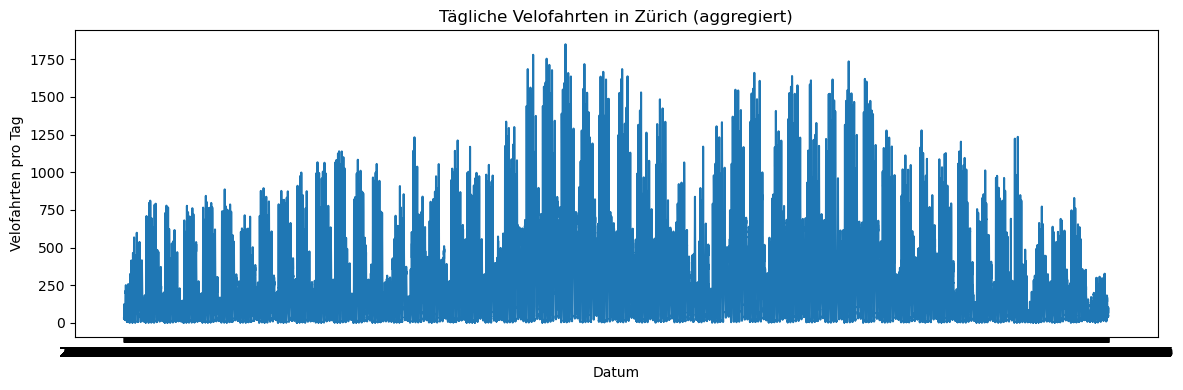

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(df_prophet["ds"], df_prophet["y"])
plt.xlabel("Datum")
plt.ylabel("Velofahrten pro Tag")
plt.title("Tägliche Velofahrten in Zürich (aggregiert)")
plt.tight_layout()
plt.show()


## Datenqualität: Fehlende Tage & Ausreißer

Vor der Modellierung wird geprüft, ob:
- Tage in der Zeitreihe fehlen (Lücken),
- extreme Ausreißer existieren,
- die Zielvariable plausibel skaliert ist.

Diese Schritte sind wichtig, damit das Modell nicht durch Datenprobleme verzerrt wird.


In [10]:
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
df_prophet.dtypes


ds    datetime64[ns]
y            float64
dtype: object

In [11]:
# Zeitstempel auf Tagesdatum bringen
df_prophet["date"] = df_prophet["ds"].dt.floor("D")

# Aggregation auf Tagesniveau
df_prophet_daily = (
    df_prophet
    .groupby("date", as_index=False)["y"]
    .sum()
    .rename(columns={"date": "ds"})
)

df_prophet_daily.head()


,ds,y
0,2023-01-01,8310.0
1,2023-01-02,9452.0
2,2023-01-03,12688.0
3,2023-01-04,17583.0
4,2023-01-05,18090.0


In [12]:
full_range = pd.date_range(
    df_prophet_daily["ds"].min(),
    df_prophet_daily["ds"].max(),
    freq="D"
)

df_prophet_full = (
    df_prophet_daily
    .set_index("ds")
    .reindex(full_range)
    .rename_axis("ds")
    .reset_index()
)

missing_days = df_prophet_full["y"].isna().sum()
missing_days


np.int64(0)

### Umgang mit fehlenden Tagen

Nach der Aggregation auf Tagesebene liegen für jeden Kalendertag Messwerte vor.
Es sind keine fehlenden Tage in der Zeitreihe vorhanden.
Eine weitere Behandlung fehlender Tage ist daher nicht erforderlich.


## Ausreißeranalyse (deskriptiv)

Zur Einschätzung der Datenverteilung werden Kennzahlen der täglichen Velofahrten betrachtet.
Dabei wird geprüft, ob extreme Werte vorliegen, die auf besondere Ereignisse
(z.B. Wetter, Grossanlässe oder Messfehler) hinweisen könnten.


In [13]:
df_prophet_daily["y"].describe(percentiles=[0.01, 0.05, 0.95, 0.99])


count      365.000000
mean     28420.205479
std      12543.450044
min       4151.000000
1%        6235.240000
5%        9678.200000
50%      27155.000000
95%      50855.600000
99%      54340.080000
max      55909.000000
Name: y, dtype: float64

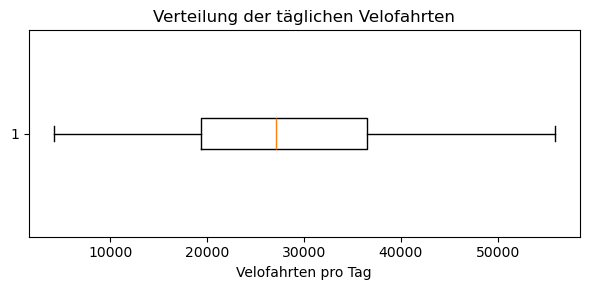

In [14]:
plt.figure(figsize=(6,3))
plt.boxplot(df_prophet_daily["y"], vert=False, showfliers=True)
plt.xlabel("Velofahrten pro Tag")
plt.title("Verteilung der täglichen Velofahrten")
plt.tight_layout()
plt.show()


Die täglichen Velofahrten weisen eine breite Verteilung auf.
Einzelne hohe Werte sind sichtbar, diese sind jedoch plausibel und können durch
saisonale Effekte, gutes Wetter oder besondere Ereignisse erklärt werden.

Die Werte werden daher unverändert für die weitere Analyse verwendet.


## Aufteilung in Trainings- und Testdaten

Zur Bewertung der Prognosegüte wird die Zeitreihe in Trainings- und Testdaten aufgeteilt.
Der Testzeitraum umfasst die letzten 90 Tage der verfügbaren Daten.


In [15]:
# Anzahl Tage im Testzeitraum festlegen
horizon_days = 90

# Trennpunkt zwischen Trainings- und Testdaten berechnen
cutoff_date = df_prophet_daily["ds"].max() - pd.Timedelta(days=horizon_days)

# Trainingsdaten: alle Tage bis inklusive Cutoff
train = df_prophet_daily[df_prophet_daily["ds"] <= cutoff_date].copy()

# Testdaten: alle Tage nach dem Cutoff
test = df_prophet_daily[df_prophet_daily["ds"] > cutoff_date].copy()

# Kontrolle der Aufteilung
train.shape, test.shape, cutoff_date


((275, 2), (90, 2), Timestamp('2023-10-02 00:00:00'))

## Prophet Baseline-Modell

Als Referenz wird ein Prophet-Modell ohne externe Einflussfaktoren verwendet.
Das Modell berücksichtigt:
- einen langfristigen Trend,
- eine wöchentliche Saisonalität,
- eine jährliche Saisonalität.

Dieses Modell dient als Vergleichsbasis für spätere Erweiterungen mit Wetterdaten.


In [16]:
# Initialisierung des Prophet-Modells
# yearly_seasonality: jährliche Muster (Sommer/Winter)
# weekly_seasonality: Unterschiede zwischen Wochentagen
# daily_seasonality: nicht notwendig bei Tagesdaten
m_base = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Modell anhand der Trainingsdaten schätzen
m_base.fit(train)


11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing


## Erstellung der Prognose

Basierend auf dem geschätzten Modell wird eine Prognose für den gesamten Zeitraum
inklusive Testdaten erzeugt.


In [17]:
# Erzeugen eines zukünftigen Datumsbereichs
# periods = Anzahl Tage, die prognostiziert werden sollen
future_base = m_base.make_future_dataframe(
    periods=horizon_days,
    freq="D"
)

# Berechnung der Prognosewerte
forecast_base = m_base.predict(future_base)

# Überblick über die Prognose
forecast_base[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()


,ds,yhat,yhat_lower,yhat_upper
0,2023-01-01,856.461833,-5939.736939,7109.520296
1,2023-01-02,14075.908917,7758.877889,21119.385280
2,2023-01-03,19334.315070,11997.204432,26007.727346
3,2023-01-04,19541.668259,12680.632352,26297.601909
4,2023-01-05,20790.729957,14219.827599,27426.979064


## Bewertung der Prognosegüte

Zur quantitativen Beurteilung der Modellleistung werden zwei Fehlermaße verwendet:
- MAE (mittlerer absoluter Fehler)
- RMSE (Wurzel des mittleren quadratischen Fehlers)

Diese Kennzahlen werden ausschließlich auf dem Testzeitraum berechnet.


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prognosewerte mit den tatsächlichen Beobachtungen im Testzeitraum zusammenführen
pred_base = forecast_base[
    ["ds", "yhat", "yhat_lower", "yhat_upper"]
].merge(
    test,
    on="ds",
    how="inner"
)

# Berechnung des mittleren absoluten Fehlers (MAE)
mae_base = mean_absolute_error(pred_base["y"], pred_base["yhat"])

# Berechnung des RMSE
rmse_base = np.sqrt(mean_squared_error(pred_base["y"], pred_base["yhat"]))

# Ausgabe der Fehlerkennzahlen
mae_base, rmse_base


(30442.3153281004, np.float64(33391.27056909591))

## Visualisierung der Prognose

Zur inhaltlichen Beurteilung wird die Prognose des Baseline-Modells
mit den beobachteten Werten im Testzeitraum verglichen.


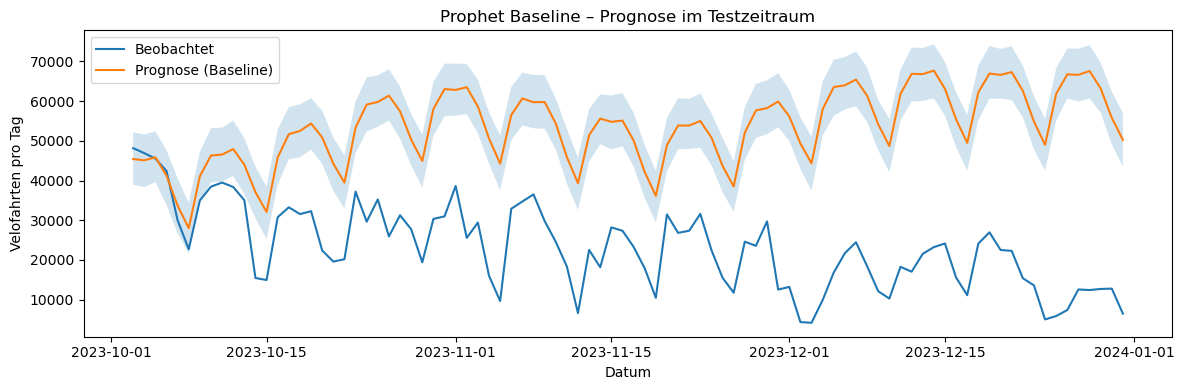

In [19]:
import matplotlib.pyplot as plt

# Zeitreihenplot für den Testzeitraum
plt.figure(figsize=(12, 4))

# Tatsächliche Beobachtungen
plt.plot(
    test["ds"],
    test["y"],
    label="Beobachtet"
)

# Prognostizierte Werte
plt.plot(
    pred_base["ds"],
    pred_base["yhat"],
    label="Prognose (Baseline)"
)

# Unsicherheitsintervall der Prognose
plt.fill_between(
    pred_base["ds"],
    pred_base["yhat_lower"],
    pred_base["yhat_upper"],
    alpha=0.2
)

# Achsenbeschriftungen und Titel
plt.xlabel("Datum")
plt.ylabel("Velofahrten pro Tag")
plt.title("Prophet Baseline – Prognose im Testzeitraum")

# Legende anzeigen
plt.legend()

# Layout optimieren
plt.tight_layout()
plt.show()


Die Prognose des Baseline-Modells zeigt systematische Abweichungen
zwischen den vorhergesagten und den beobachteten Werten im Testzeitraum.

Ein wesentlicher Grund dafür ist die begrenzte Datenbasis:
Die Zeitreihe umfasst nur ein Jahr, wodurch saisonale Effekte
(insbesondere die jährliche Saisonalität) nur einmal beobachtet werden.
Dies erschwert eine stabile Schätzung durch das Modell.

Das Baseline-Modell dient daher primär als Referenz und Motivation
für die Erweiterung um erklärende externe Einflussfaktoren.


## Aufbereitung der Wetterdaten

Die Wetterdaten liegen im Long-Format vor, wobei jede Zeile einen Messwert
für einen bestimmten Parameter enthält.
Für die Modellierung werden ausgewählte Wetterparameter auf Tagesebene
aggregiert und in ein Wide-Format überführt.


In [20]:
# Kopie der Wetterdaten erstellen, um das Original nicht zu verändern
df_weather = wetter.copy()

# Datumsspalte in Datetime-Format umwandeln
df_weather["Datum"] = pd.to_datetime(df_weather["Datum"])

# Tagesdatum extrahieren (Zeitanteil entfernen)
df_weather["ds"] = df_weather["Datum"].dt.floor("D")

# Überblick über vorhandene Wetterparameter
df_weather["Parameter"].value_counts()


Parameter
T           1095
RainDur     1095
p           1095
T_max_h1    1095
StrGlo       365
Name: count, dtype: int64

## Auswahl und Aggregation der Wetterparameter

Für die Analyse werden zwei Wetterparameter ausgewählt:
- Tagesmaximum der Temperatur (`T_max_h1`)
- tägliche Niederschlagsmenge (`p`)

Diese Auswahl erlaubt eine kompakte und interpretierbare Modellierung
des Wettereinflusses auf die Velofahrten.


In [21]:
# Auswahl der relevanten Wetterparameter
selected_params = ["T_max_h1", "p"]

df_weather_sel = df_weather[
    df_weather["Parameter"].isin(selected_params)
].copy()

# Aggregation auf Tagesebene:
# - Temperaturmaximum: Maximum pro Tag
# - Niederschlag: Summe pro Tag
temp_max_daily = (
    df_weather_sel[df_weather_sel["Parameter"] == "T_max_h1"]
    .groupby("ds")["Wert"]
    .max()
    .rename("temp_max")
)

rain_daily = (
    df_weather_sel[df_weather_sel["Parameter"] == "p"]
    .groupby("ds")["Wert"]
    .sum()
    .rename("rain_sum")
)

# Zusammenführen der Wettervariablen
df_weather_daily = pd.concat(
    [temp_max_daily, rain_daily],
    axis=1
).reset_index()

df_weather_daily.head()


,ds,temp_max,rain_sum
0,2023-01-01 00:00:00+01:00,15.43,2918.40
1,2023-01-02 00:00:00+01:00,14.86,2919.15
2,2023-01-03 00:00:00+01:00,9.46,2938.84
3,2023-01-04 00:00:00+01:00,11.58,2937.10
4,2023-01-05 00:00:00+01:00,12.21,2927.37


## Zusammenführung von Verkehrs- und Wetterdaten

Die aggregierten Wetterdaten werden über das Datum (`ds`)
mit den täglichen Velofahrten zusammengeführt.


In [22]:
# Zeitzoneninformation aus den Wetterdaten entfernen
df_weather_daily["ds"] = df_weather_daily["ds"].dt.tz_localize(None)

# Kontrolle der Datentypen
df_weather_daily.dtypes


ds          datetime64[ns]
temp_max           float64
rain_sum           float64
dtype: object

In [23]:
# Merge der Velodaten mit den Wetterdaten
df_model = df_prophet_daily.merge(
    df_weather_daily,
    on="ds",
    how="left"
)

# Kontrolle auf fehlende Werte
df_model.isna().sum()


ds          0
y           0
temp_max    0
rain_sum    0
dtype: int64

## Train/Test-Split für das Wettermodell

Für den Vergleich mit dem Baseline-Modell wird derselbe Trainings-
und Testzeitraum verwendet.


In [24]:
# Trainingsdaten für das Wettermodell
train_w = df_model[df_model["ds"] <= cutoff_date].copy()

# Testdaten für das Wettermodell
test_w = df_model[df_model["ds"] > cutoff_date].copy()

# Kontrolle der Dimensionen
train_w.shape, test_w.shape


((275, 4), (90, 4))

## Prophet-Modell mit Wetter-Regressoren

Zur Prüfung von Hypothese H1 werden Wettervariablen als externe Regressoren
in das Prophet-Modell integriert.


In [25]:
from prophet import Prophet

# Initialisierung des Prophet-Modells
m_weather = Prophet(
    yearly_seasonality=True,   # jährliche Saisonalität
    weekly_seasonality=True,   # wöchentliche Saisonalität
    daily_seasonality=False    # keine tägliche Saisonalität (Tagesdaten)
)

# Hinzufügen der Wettervariablen als Regressoren
m_weather.add_regressor("temp_max")   # Tagesmaximum der Temperatur
m_weather.add_regressor("rain_sum")   # tägliche Niederschlagsmenge

# Modell anhand der Trainingsdaten schätzen
m_weather.fit(train_w)


11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing


## Prognose mit Wettermodell

Basierend auf dem erweiterten Modell wird eine Prognose für den Testzeitraum erstellt.


In [26]:
# Erzeugen des zukünftigen Datumsbereichs
future_weather = m_weather.make_future_dataframe(
    periods=horizon_days,
    freq="D"
)

# Wetterwerte an den Zukunfts-DataFrame anhängen
future_weather = future_weather.merge(
    df_model[["ds", "temp_max", "rain_sum"]],
    on="ds",
    how="left"
)

# Prognose berechnen
forecast_weather = m_weather.predict(future_weather)

forecast_weather[["ds", "yhat"]].head()


,ds,yhat
0,2023-01-01,2898.238938
1,2023-01-02,16104.185743
2,2023-01-03,17796.816839
3,2023-01-04,19931.118863
4,2023-01-05,21186.254039


## Vergleich der Prognosegüte

Die Prognosegüte des Wettermodells wird anhand von MAE und RMSE
mit dem Baseline-Modell verglichen.


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prognose und Beobachtungen im Testzeitraum zusammenführen
pred_weather = forecast_weather[
    ["ds", "yhat"]
].merge(
    test_w[["ds", "y"]],
    on="ds",
    how="inner"
)

# Berechnung der Fehlerkennzahlen
mae_weather = mean_absolute_error(pred_weather["y"], pred_weather["yhat"])
rmse_weather = np.sqrt(mean_squared_error(pred_weather["y"], pred_weather["yhat"]))

# Vergleich mit dem Baseline-Modell
mae_base, rmse_base, mae_weather, rmse_weather


(30442.3153281004,
 np.float64(33391.27056909591),
 23494.156274562436,
 np.float64(26214.9199352367))

## Vergleich der Prognosen

Die Prognose des Wettermodells wird visuell mit den beobachteten Werten
im Testzeitraum verglichen.


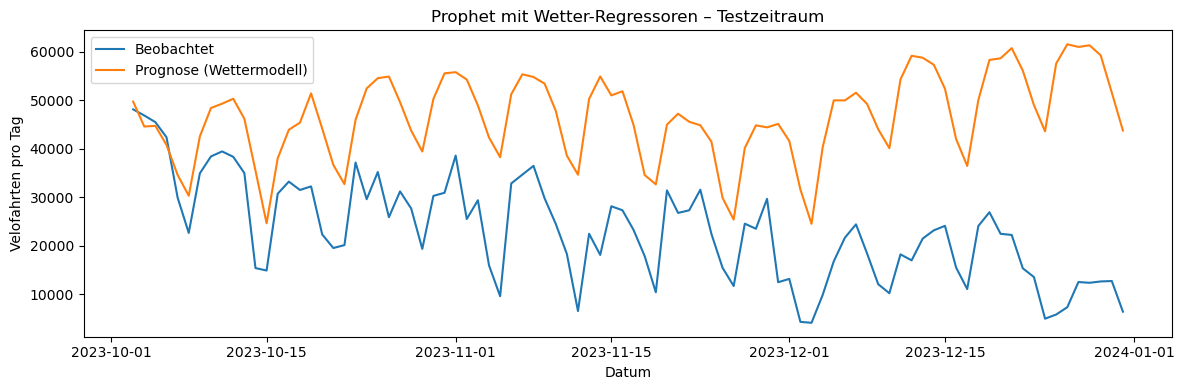

In [28]:
plt.figure(figsize=(12, 4))

# Beobachtete Werte
plt.plot(test_w["ds"], test_w["y"], label="Beobachtet")

# Prognose mit Wettermodell
plt.plot(pred_weather["ds"], pred_weather["yhat"], label="Prognose (Wettermodell)")

plt.xlabel("Datum")
plt.ylabel("Velofahrten pro Tag")
plt.title("Prophet mit Wetter-Regressoren – Testzeitraum")
plt.legend()
plt.tight_layout()
plt.show()


11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing


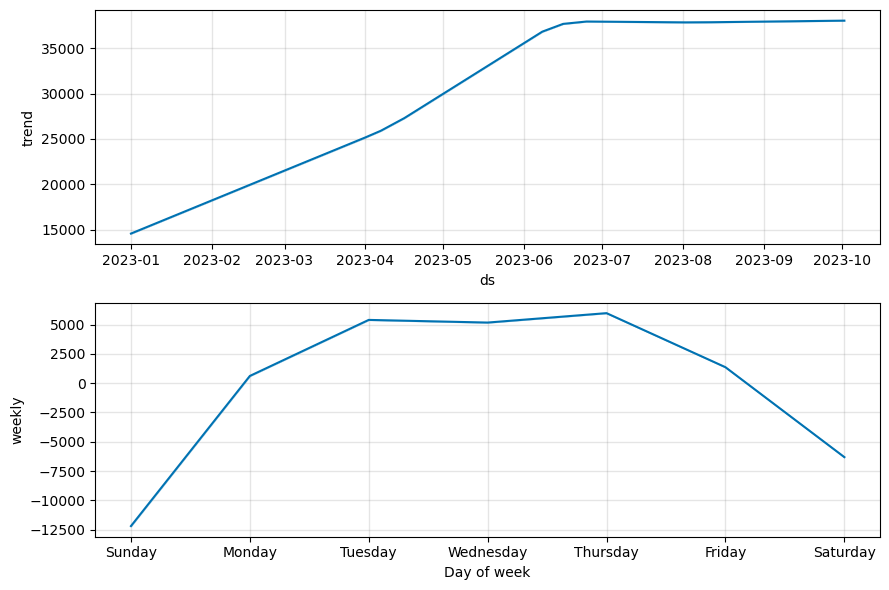

In [29]:
# Prophet mit Unsicherheiten (Standard, aber explizit)
m_week = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.8,          # 80%-Unsicherheitsintervall
    changepoint_prior_scale=0.1  # wenige / konservative Change-Points
)

m_week.fit(train)

future_week = m_week.make_future_dataframe(periods=0)
forecast_week = m_week.predict(future_week)

m_week.plot_components(forecast_week)
plt.show()


Der Trend zeigt eine Zunahme der Velofahrten bis in die Sommermonate,
gefolgt von einer Stabilisierung.
Die wöchentliche Saisonalität weist klare Unterschiede zwischen Werktagen
und Wochenendtagen auf, wobei der Sonntag den niedrigsten Wert aufweist.

Die ausgeprägte wöchentliche Struktur im Vergleich zum relativ glatten Trend
deutet darauf hin, dass kurzfristige Schwankungen stark durch das
Wochenmuster geprägt sind.


## Einordnung der Prophet-Ergebnisse

Das Prophet-Modell wurde eingesetzt, um den langfristigen Trend sowie
saisonale Muster der Velofahrten zu analysieren.
Insbesondere die wöchentliche Saisonalität kann mit dem Modell klar
identifiziert werden.

Die Ergebnisse zeigen ausgeprägte Unterschiede zwischen den Wochentagen:
Werktage weisen deutlich höhere Velofahrten auf als Wochenendtage,
wobei insbesondere der Sonntag stark unter dem Wochenmittel liegt.
Diese Effekte sind konsistent und gut interpretierbar.

Hingegen ist die Prognosegüte im Testzeitraum eingeschränkt.
Ein zentraler Grund dafür ist die begrenzte Länge der Zeitreihe:
Da nur ein Jahr an Daten vorliegt, kann die jährliche Saisonalität
nur einmal beobachtet werden und somit nicht stabil geschätzt werden.
Dies führt insbesondere im Winterhalbjahr zu systematischen Abweichungen
zwischen Prognose und Beobachtung.

Das Prophet-Modell wird daher im Folgenden primär zur explorativen
Analyse von Trend und wöchentlicher Saisonalität genutzt.
Für die detaillierte Untersuchung externer Einflüsse wie Wetterbedingungen
wird ein alternativer Zeitreihenansatz gewählt. Prophet wird nicht verworfen, sondern dient als Motivation für STL.


## Motivation für die Zeitreihen-Dekomposition

Anstatt alle Effekte gleichzeitig in einem Prognosemodell abzubilden,
wird im nächsten Schritt ein klassischer Zeitreihenansatz gewählt.

Durch die Zerlegung der Zeitreihe in Trend, saisonale Komponente
und Residuen können kurzfristige Abweichungen gezielt analysiert werden.
Insbesondere eignen sich die Residuen, um den Einfluss externer Faktoren
wie Wetterbedingungen isoliert zu untersuchen.

Dieser Ansatz ist besser an die vorliegende Datenlage angepasst
und erlaubt eine transparentere und interpretierbare Analyse
der Hypothese H1.


## Vorbereitung der Velodaten für die Zeitreihenanalyse

Die Velodaten liegen in 15-Minuten-Intervallen vor.
Für die Zeitreihenanalyse werden diese auf Tagesebene aggregiert,
indem alle Velofahrten eines Tages aufsummiert werden.


In [30]:
# Kopie der Velodaten erstellen
df_velo = velo.copy()

# Datumsvariable in Datetime-Format umwandeln
df_velo["DATUM"] = pd.to_datetime(df_velo["DATUM"])

# Tagesdatum extrahieren
df_velo["ds"] = df_velo["DATUM"].dt.floor("D")

# Zielvariable: gesamte Velofahrten pro Intervall
df_velo["velo_total"] = df_velo["VELO_IN"] + df_velo["VELO_OUT"]

# Aggregation auf Tagesebene
df_velo_daily = (
    df_velo
    .groupby("ds", as_index=False)["velo_total"]
    .sum()
    .rename(columns={"velo_total": "y"})
)

df_velo_daily.head()


,ds,y
0,2023-01-01,8310.0
1,2023-01-02,9452.0
2,2023-01-03,12688.0
3,2023-01-04,17583.0
4,2023-01-05,18090.0


## Zeitreihen-Dekomposition mit STL

Um den langfristigen Trend, das wöchentliche Muster und kurzfristige
Schwankungen getrennt zu analysieren, wird die Zeitreihe mittels
STL (Seasonal-Trend decomposition using Loess) zerlegt.

STL ist robust gegenüber Ausreißern und eignet sich gut für
Zeitreihen mit ausgeprägter wöchentlicher Saisonalität.


In [31]:
from statsmodels.tsa.seasonal import STL

# Zeitreihe als pandas Series mit Datumsindex vorbereiten
ts = (
    df_velo_daily
    .set_index("ds")["y"]
    .asfreq("D")  # explizit tägliche Frequenz setzen
)

ts.head()


ds
2023-01-01     8310.0
2023-01-02     9452.0
2023-01-03    12688.0
2023-01-04    17583.0
2023-01-05    18090.0
Freq: D, Name: y, dtype: float64

In [32]:
# STL-Dekomposition
# period=7 -> wöchentliche Saisonalität (Tagesdaten)
stl = STL(
    ts,
    period=7,
    robust=True  # robust gegenüber Ausreißern
)

stl_result = stl.fit()


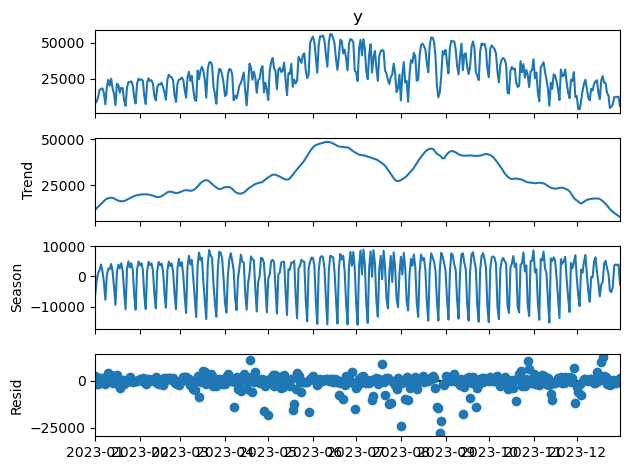

In [33]:
# Darstellung der STL-Komponenten
stl_result.plot()
plt.tight_layout()
plt.show()


## Interpretation der STL-Dekomposition

Die STL-Dekomposition zerlegt die Zeitreihe der täglichen Velofahrten
in eine Trendkomponente, eine saisonale Komponente und Residuen.

Der **Trend** beschreibt die langfristige Entwicklung der Velofahrten
über den Beobachtungszeitraum.
Er zeigt einen Anstieg der Velofahrten vom Winter bis in die Sommermonate
sowie einen Rückgang im Herbst und Winter.
Dieser Verlauf deutet auf einen jahreszeitlichen Zusammenhang hin
und dient als Grundlage zur Beurteilung von Hypothese H3.
Aufgrund der verfügbaren Daten von nur einem Jahr kann jedoch
keine stabile jährliche Saisonalität identifiziert werden,
sondern lediglich der übergeordnete saisonale Verlauf im Trend.

Die **saisonale Komponente** weist auf eine regelmäßige, kurzperiodische
Struktur in der Zeitreihe hin.
Aus der Darstellung über die Zeit lassen sich jedoch die einzelnen
Wochentagseffekte nicht eindeutig ablesen.
Zur gezielten Beurteilung von Hypothese H2 wird die saisonale Komponente
daher im nächsten Schritt explizit nach Wochentagen ausgewertet.

Die **Residuen** enthalten kurzfristige Abweichungen, die weder durch
den langfristigen Trend noch durch die kurzperiodische Struktur erklärt werden.
Diese Abweichungen eignen sich zur Analyse externer Einflussfaktoren
wie Wetterbedingungen.


In [34]:
# STL-Komponenten in einen DataFrame überführen
df_stl = pd.DataFrame({
    "ds": ts.index,
    "y": ts.values,
    "trend": stl_result.trend,
    "seasonal": stl_result.seasonal,
    "residuals": stl_result.resid
})

# NaNs entfernen (entstehen am Rand durch STL)
df_stl = df_stl.dropna().reset_index(drop=True)

df_stl.head()


,ds,y,trend,seasonal,residuals
0,2023-01-01,8310.0,11922.403000,-6001.870250,2389.467250
1,2023-01-02,9452.0,12697.284308,-1262.228108,-1983.056199
2,2023-01-03,12688.0,13466.253294,1123.693089,-1901.946383
3,2023-01-04,17583.0,14223.903749,2106.957228,1252.139024
4,2023-01-05,18090.0,14971.896276,3894.148891,-776.045167


In [35]:
# Wochentag ableiten (Montag=0, Sonntag=6)
df_stl["weekday"] = df_stl["ds"].dt.weekday

weekday_map = {
    0: "Montag",
    1: "Dienstag",
    2: "Mittwoch",
    3: "Donnerstag",
    4: "Freitag",
    5: "Samstag",
    6: "Sonntag"
}

df_stl["weekday_name"] = df_stl["weekday"].map(weekday_map)


In [36]:
weekday_season = (
    df_stl
    .groupby("weekday_name")["seasonal"]
    .agg(["mean", "std", "count"])
    .reindex(["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"])
)

weekday_season


,mean,std,count
weekday_name,,,
Montag,1836.542577,2115.637724,52
Dienstag,4810.994931,2849.832758,52
Mittwoch,4902.798896,2412.960506,52
Donnerstag,5409.875539,1609.898044,52
Freitag,2283.281955,1797.242923,52
Samstag,-6770.865300,2762.167529,52
Sonntag,-12208.961869,2923.944630,53


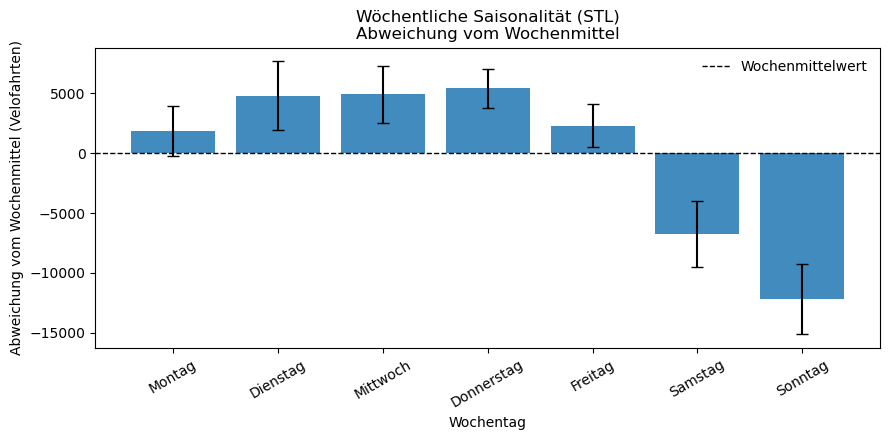

In [37]:
plt.figure(figsize=(9,4.5))

# Balkendiagramm mit Fehlerbalken
plt.bar(
    weekday_season.index,
    weekday_season["mean"],
    yerr=weekday_season["std"],
    capsize=4,
    alpha=0.85
)

# Referenzlinie: Wochenmittelwert
plt.axhline(
    0,
    color="black",
    linestyle="--",
    linewidth=1,
    label="Wochenmittelwert"
)

# Achsen & Titel
plt.ylabel("Abweichung vom Wochenmittel (Velofahrten)")
plt.xlabel("Wochentag")
plt.title("Wöchentliche Saisonalität (STL)\nAbweichung vom Wochenmittel")

# Layout-Feinschliff
plt.xticks(rotation=30)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


## Bewertung von Hypothese H2 (Wochentagseffekte)

Der dargestellte Wochentagseffekt basiert auf der saisonalen Komponente
der STL-Dekomposition und nicht auf den Rohdaten der Velofahrten.
Damit werden langfristige Trends und jahreszeitliche Schwankungen
aus der Analyse entfernt.

Die Ergebnisse zeigen klare Unterschiede zwischen Werktagen und Wochenendtagen.
Von Dienstag bis Donnerstag sind die saisonalen Effekte deutlich positiv,
während Samstag und insbesondere Sonntag stark negative Effekte aufweisen.
Die Fehlerbalken sind im Vergleich zur Höhe der Effekte moderat,
was auf ein stabiles und robustes Wochenmuster hindeutet.

Hypothese H2 wird somit klar unterstützt.


## Prüfung von Hypothese H1 (Wettereffekte)

Zur Untersuchung des Wettereinflusses werden die Residuen der
STL-Dekomposition analysiert.
Diese Residuen enthalten kurzfristige Abweichungen, die weder durch
den langfristigen Trend noch durch die wöchentliche Saisonalität erklärt werden.

Ein Zusammenhang zwischen Wetterbedingungen und Residuen deutet darauf hin,
dass Wetter vor allem kurzfristige Schwankungen der Velofahrten beeinflusst.


In [38]:
# Kopie der Wetterdaten
df_weather = wetter.copy()

# Datum in Datetime-Format umwandeln
df_weather["Datum"] = pd.to_datetime(df_weather["Datum"])

# Tagesdatum extrahieren
df_weather["ds"] = df_weather["Datum"].dt.floor("D")

# Auswahl relevanter Wetterparameter
# - T_max_h1 : Tagesmaximum Temperatur
# - p        : Niederschlagsmenge
# - RainDur  : Regendauer (entscheidend für H1)
selected_params = ["T_max_h1", "p", "RainDur"]
df_weather_sel = df_weather[df_weather["Parameter"].isin(selected_params)].copy()

# -----------------------------
# Temperatur: Tagesmaximum
temp_daily = (
    df_weather_sel[df_weather_sel["Parameter"] == "T_max_h1"]
    .groupby("ds")["Wert"]
    .max()
    .rename("temp_max")
)

# -----------------------------
# Niederschlagsmenge: Tagessumme
rain_sum_daily = (
    df_weather_sel[df_weather_sel["Parameter"] == "p"]
    .groupby("ds")["Wert"]
    .sum()
    .rename("rain_sum")
)

# -----------------------------
# Regendauer: gesamte Dauer pro Tag
rain_dur_daily = (
    df_weather_sel[df_weather_sel["Parameter"] == "RainDur"]
    .groupby("ds")["Wert"]
    .sum()
    .rename("rain_dur")
)

# -----------------------------
# Zusammenführen aller Wettervariablen
df_weather_daily = pd.concat(
    [temp_daily, rain_sum_daily, rain_dur_daily],
    axis=1
).reset_index()

# Zeitzone entfernen (falls vorhanden)
df_weather_daily["ds"] = df_weather_daily["ds"].dt.tz_localize(None)

df_weather_daily.head()


,ds,temp_max,rain_sum,rain_dur
0,2023-01-01,15.43,2918.40,0.00
1,2023-01-02,14.86,2919.15,294.34
2,2023-01-03,9.46,2938.84,1430.11
3,2023-01-04,11.58,2937.10,36.77
4,2023-01-05,12.21,2927.37,209.38


In [39]:
df_h1 = df_stl.merge(
    df_weather_daily,
    on="ds",
    how="left"
)

df_h1.isna().sum()


ds              0
y               0
trend           0
seasonal        0
residuals       0
weekday         0
weekday_name    0
temp_max        0
rain_sum        0
rain_dur        0
dtype: int64

### Einfluss von Niederschlag auf die Residuen

Zunächst wird untersucht, ob an Regentagen systematisch
negativere Residuen auftreten als an trockenen Tagen.


In [40]:
df_h1.columns


Index(['ds', 'y', 'trend', 'seasonal', 'residuals', 'weekday', 'weekday_name',
       'temp_max', 'rain_sum', 'rain_dur'],
      dtype='object')

In [41]:
# Überblick über die Regendauer
# Ziel: sicherstellen, dass es Variation gibt
df_h1["rain_dur"].describe()


count     365.000000
mean      367.267836
std       628.504217
min         0.000000
25%         0.000000
50%        41.480000
75%       509.110000
max      4304.470000
Name: rain_dur, dtype: float64

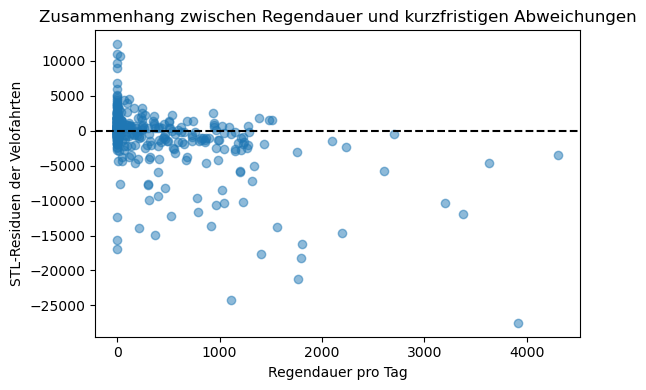

In [42]:
import matplotlib.pyplot as plt

# Scatterplot: Regendauer vs. STL-Residuen
plt.figure(figsize=(6,4))

plt.scatter(
    df_h1["rain_dur"],
    df_h1["residuals"],
    alpha=0.5
)

# Referenzlinie bei Residuum = 0
plt.axhline(0, color="black", linestyle="--")

plt.xlabel("Regendauer pro Tag")
plt.ylabel("STL-Residuen der Velofahrten")
plt.title("Zusammenhang zwischen Regendauer und kurzfristigen Abweichungen")
plt.tight_layout()
plt.show()


In [43]:
# Regendauer von Sekunden in Stunden umrechnen
df_h1["rain_dur_h"] = df_h1["rain_dur"] / 3600


In [44]:
# Sicherheit: nur Tage mit gültiger Regendauer
df_h1 = df_h1.dropna(subset=["rain_dur"]).copy()

# Regendauer in Minuten (falls sie noch nicht in Minuten ist)
# -> falls rain_dur schon Minuten ist, diese Zeile einfach löschen
# df_h1["rain_dur"] = df_h1["rain_dur"] / 60

# Einteilung der Regendauer in inhaltlich sinnvolle Tagesklassen
df_h1["rain_bin"] = pd.cut(
    df_h1["rain_dur"],
    bins=[0, 30, 120, 480, 1440, 10000],  # feste obere Grenze
    labels=[
        "0–30 min",
        "30–120 min",
        "2–8 h",
        "8–24 h",
        ">24 h"
    ],
    include_lowest=True
)

df_h1["rain_bin"].value_counts()


rain_bin
0–30 min      174
8–24 h         79
2–8 h          63
30–120 min     32
>24 h          17
Name: count, dtype: int64

<Figure size 800x400 with 0 Axes>

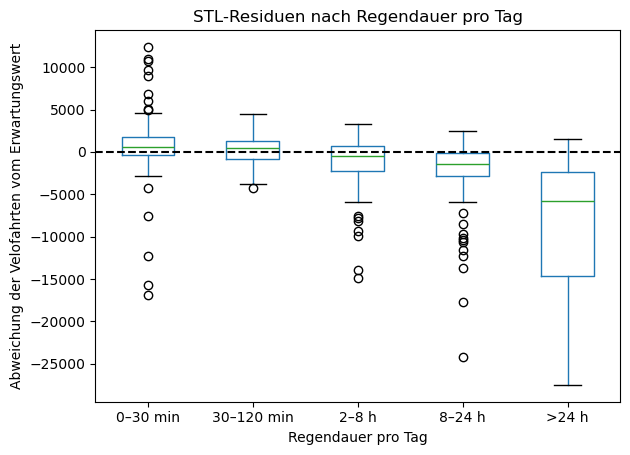

In [45]:
plt.figure(figsize=(8,4))

df_h1.boxplot(
    column="residuals",
    by="rain_bin",
    grid=False
)

plt.axhline(0, color="black", linestyle="--")
plt.title("STL-Residuen nach Regendauer pro Tag")
plt.suptitle("")
plt.xlabel("Regendauer pro Tag")
plt.ylabel("Abweichung der Velofahrten vom Erwartungswert")
plt.tight_layout()
plt.show()


/var/folders/c1/0dl4hf910zl01g3hj23gbs1m0000gn/T/ipykernel_2687/363157752.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_h1.groupby("rain_bin")["residuals"]


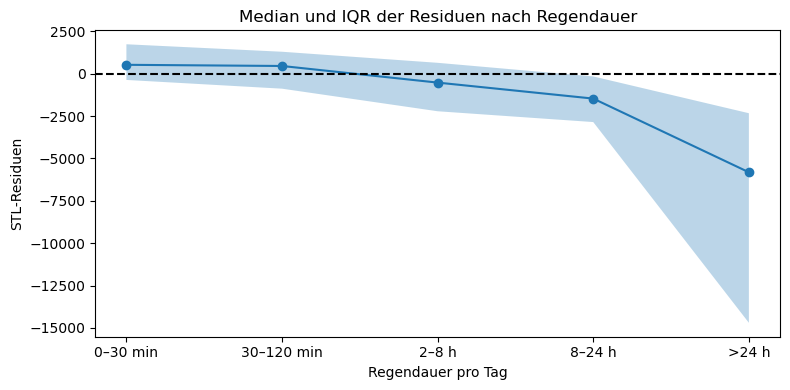

In [46]:
summary = (
    df_h1.groupby("rain_bin")["residuals"]
    .agg(median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75))
)

plt.figure(figsize=(8,4))

plt.plot(summary.index, summary["median"], marker="o")
plt.fill_between(
    summary.index,
    summary["q25"],
    summary["q75"],
    alpha=0.3
)

plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Regendauer pro Tag")
plt.ylabel("STL-Residuen")
plt.title("Median und IQR der Residuen nach Regendauer")
plt.tight_layout()
plt.show()


In [47]:
import statsmodels.formula.api as smf

model_h1 = smf.ols(
    "residuals ~ rain_dur",
    data=df_h1
).fit()

model_h1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              residuals   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     118.7
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           4.12e-24
Time:                        11:55:19   Log-Likelihood:                -3538.6
No. Observations:                 365   AIC:                             7081.
Df Residuals:                     363   BIC:                             7089.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    386.4403    238.856      1.618      0.107     -83.274     856.155
rain_dur      -3.5791      0.328    -10.897      0.000      -4.225      -2.933
==============================================================================
Omnibus:                      137.576   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              669.878
Skew:                          -1.541   Prob(JB):                    3.45e-146
Kurtosis:                       8.878   Cond. No.                         843.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Zur Prüfung von Hypothese H1 wurde ein lineares Regressionsmodell
mit den STL-Residuen als Zielvariable geschätzt.
Das Modell zeigt einen signifikanten negativen Zusammenhang
zwischen der Regendauer und den Residuen der Velofahrten.

Mit zunehmender Regendauer werden im Mittel geringere Velofahrten
beobachtet, als aufgrund von Trend und wöchentlicher Saisonalität
zu erwarten wäre.
Der Effekt ist statistisch hochsignifikant und erklärt einen
substanziellen Anteil der kurzfristigen Abweichungen.

Hypothese H1 wird damit klar bestätigt.
